In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the data

- Training Features
- Training Labels
- Test Features

In [5]:
train_features = pd.read_csv(
    'data/training_set_features.csv',
    index_col='respondent_id'
)

train_labels = pd.read_csv(
    'data/training_set_labels.csv',
    index_col='respondent_id'
)

print(train_labels.shape)
train_features.head()

(26707, 2)


,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


We have 35 features and 2607 observations

In [6]:
train_features.dtypes

h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                            object
sex                             object
income_poverty           

### Let's double-check that rows between the features and the labels match up.

In [7]:
np.testing.assert_array_equal(train_features.index.values, train_labels.index.values)

### Check if target variables classes are balanced

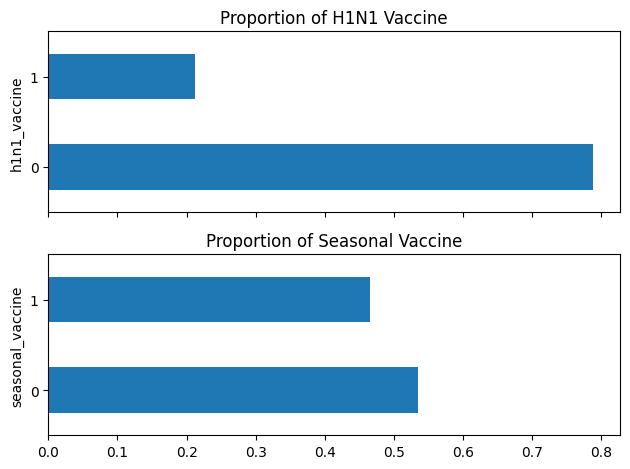

In [8]:
fig, ax = plt.subplots(2, 1, sharex=True)

n_obs = train_labels.shape[0]

(train_labels['h1n1_vaccine']
    .value_counts()
    .div(n_obs)
    .plot.barh(title="Proportion of H1N1 Vaccine", ax=ax[0])
)
ax[0].set_ylabel("h1n1_vaccine")

(train_labels['seasonal_vaccine']
    .value_counts()
    .div(n_obs)
    .plot.barh(title="Proportion of Seasonal Vaccine", ax=ax[1])
)
ax[1].set_ylabel("seasonal_vaccine")

fig.tight_layout()

It looks like season flue vaccine target has balanced classes, but the N1N1 flu vaccine has moderately imbalanced classes

### Let's check if the two target variables are independent

In [9]:
pd.crosstab(
    train_labels["h1n1_vaccine"], 
    train_labels["seasonal_vaccine"], 
    margins=True,
    normalize=True
)

seasonal_vaccine,0,1,All
h1n1_vaccine,,,
0,0.497810,0.289737,0.787546
1,0.036582,0.175871,0.212454
All,0.534392,0.465608,1.000000


In [10]:
train_labels["h1n1_vaccine"].corr(train_labels["seasonal_vaccine"], method="pearson")

np.float64(0.37714265306144495)

That indicates that we have a moderate positive correlation, most people who got an H1N1 flu vaccine got the seasonal flu vaccine.
While a minority of people who got the seasonal vaccine got the H1N1 vaccine, they got the H1N1 vaccine at a higer rate than those who did not get the seasonal vaccine.

### Let's have a look at features distribution impact on h1n1_vaccine and seasonal_vaccine

In [11]:
joined_df = train_features.join(train_labels)

def vaccination_rate_plot(col, target, data, ax=None):
    counts = (joined_df[[target, col]]
                  .groupby([target, col])
                  .size()
                  .unstack(target)
             )
    group_counts = counts.sum(axis='columns')
    props = counts.div(group_counts, axis='index')

    props.plot(kind="barh", stacked=True, ax=ax)
    ax.invert_yaxis()
    ax.legend().remove()


If a feature is correlated with the target, we expect there to be different patterns of vaccination as you vary the values of the feature.
To explore this we groupped the rows by different values of features and put into the bar chart distribution of target features in the groups.

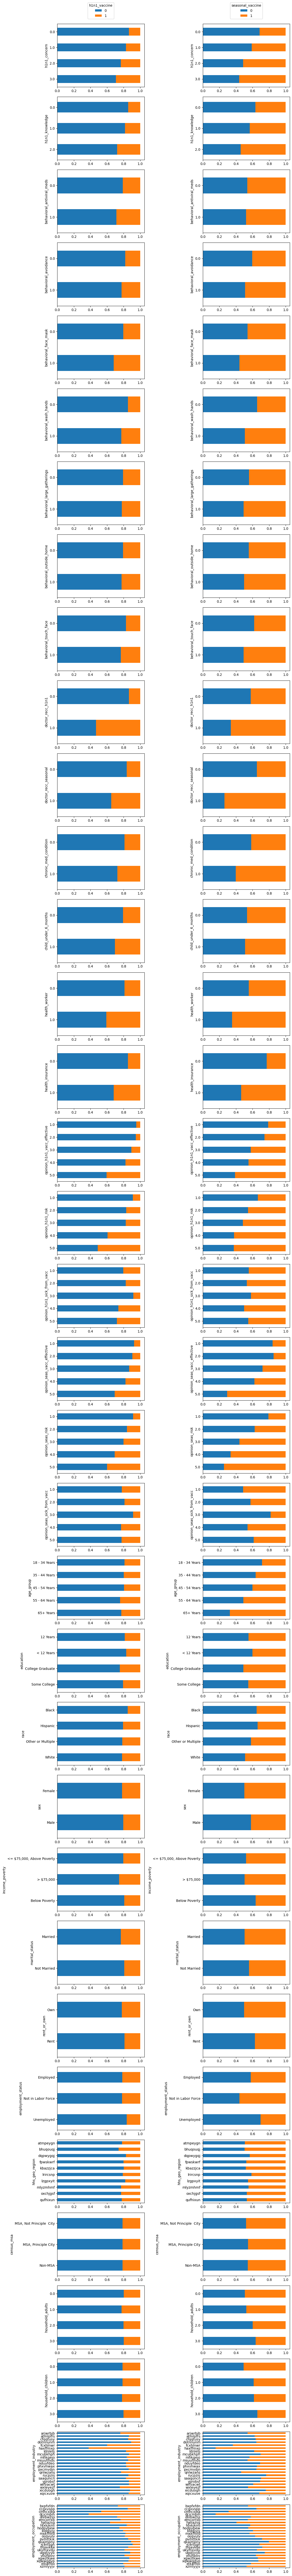

In [12]:
fig, ax = plt.subplots(
    len(train_features.columns), 2, figsize=(12,len(train_features.columns)*3)
)
for idx, col in enumerate(train_features.columns):
    vaccination_rate_plot(
        col, 'h1n1_vaccine', joined_df, ax=ax[idx, 0]
    )
    vaccination_rate_plot(
        col, 'seasonal_vaccine', joined_df, ax=ax[idx, 1]
    )
    
ax[0, 0].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine'
)
ax[0, 1].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine'
)
fig.tight_layout()

For now we can see that the demographic features have stronger correlation with seasonal_vaccine, but much less so far h1n1_vaccine. In particular, we interestingly see a strong correlation with age_group with the seasonal_vaccine but not with h1n1_vaccine.

### Now, let's validate our result with correlation matrix

We've chosen numerical features to calculate person correlation between them and the target variables.

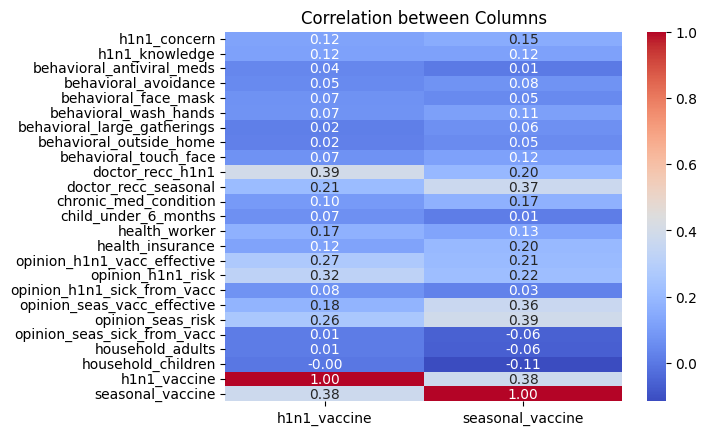

In [13]:
corr_df = joined_df[[
    'h1n1_concern',
    'h1n1_knowledge',              
    'behavioral_antiviral_meds',
    'behavioral_avoidance',
    'behavioral_face_mask',
    'behavioral_wash_hands',
    'behavioral_large_gatherings',
    'behavioral_outside_home',
    'behavioral_touch_face',
    'doctor_recc_h1n1',
    'doctor_recc_seasonal',
    'chronic_med_condition',          
    'child_under_6_months',         
    'health_worker',        
    'health_insurance',       
    'opinion_h1n1_vacc_effective',    
    'opinion_h1n1_risk',   
    'opinion_h1n1_sick_from_vacc',  
    'opinion_seas_vacc_effective', 
    'opinion_seas_risk',
    'opinion_seas_sick_from_vacc',
    'household_adults',
    'household_children',
    'h1n1_vaccine',
    'seasonal_vaccine'
]]

corr = corr_df.corr(method='pearson')
corr = corr.loc[:, ['h1n1_vaccine', 'seasonal_vaccine']]

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation between Columns')
plt.show()

From this we can see that that the most impactful features are:
- doctor_recc_h1n1
- doctor_recc_seasonal
- opinion_h1n1_vacc_effective
- opinion_h1n1_risk

### Let's formulate sweetwiz report on our data

In [14]:
import sweetviz as sv

my_report = sv.analyze(train_features.join(train_labels))
my_report.show_html()

                                             |          | [  0%]   00:00 -> (? left)

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:02 -> (00:00 left)


Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In the report we can see, that employment_industry and employment occupation are dependent to each other and correlates with some other features.
That may mess up model in the future.